### Учимся по тексту сообщения в диалоге с другом определять, вы его отправили или он вам.

Обучаем классификатор и оцениваем его работу.

---



Импортируем библиотеки, устанавливаем тип и размер шрифта и графиков.

In [1]:
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 18})
plot_size = (15, 10)

Скачивание данных из ВК. Скрипт забирает все сообщения с человеком _uid_ непустым текстом и клаёт их в файл _filename_.

In [2]:
import get_data
uid = 123456789
get_data.download_message_history(uid)

Starting to download messages from your dialog with user 123456789 from Vkontakte
Completed!                


In [3]:
df = pd.read_csv("messages.csv", delimiter="\t")
df.head(3)

,id,timestamp,text,has_fwd,has_attachments,is_out
0,850846,1592897282,"По сообщению будем определять, кто его отправил!",0,0,1
1,850845,1592897254,Чем же?),0,0,0
2,850845,1592897254,"Финес! Я знаю, чем мы займёмся сегодня!",0,0,1


Немного обработаем датасет. Добавим длину сообщения (число слов), преобразуем timestamp в формат даты.

In [4]:
df["n_words"] = df["text"].apply(lambda string: len(string.split()))
df["length"] =  df["text"].str.len()
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

df.head(3)

,id,timestamp,text,has_fwd,has_attachments,is_out,n_words,length
0,850846,2020-06-23 07:28:02,"По сообщению будем определять, кто его отправил!",0,0,1,7,48
1,850845,2020-06-23 07:27:34,Чем же?),0,0,0,2,8
2,850845,2020-06-23 07:27:34,"Финес! Я знаю, чем мы займёмся сегодня!",0,0,1,7,39


Соберём статистику по датасету.

Размер выборки: 149071 сообщений


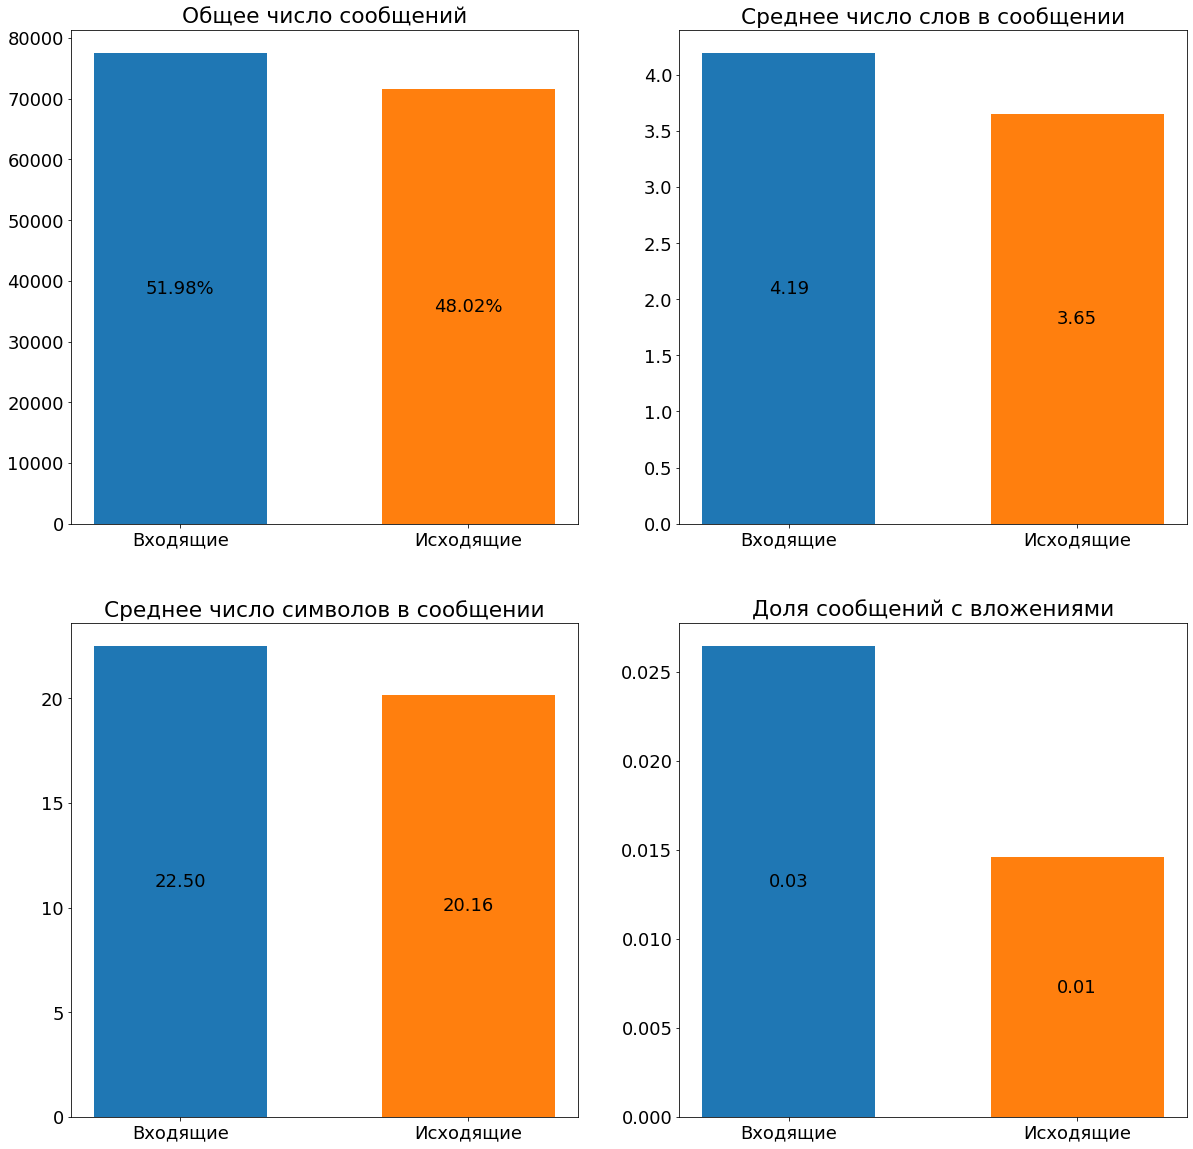

In [5]:
print(f"Размер выборки: {df.shape[0]} сообщений")

m_in = df[df["is_out"] == 0]
m_out = df[df["is_out"] == 1]
_, axes = plt.subplots(2, 2, figsize=(20, 20))
has_attachments_m_in_n = m_in[m_in["has_attachments"] == 1].shape[0]
has_attachments_m_out_n = m_out[m_out["has_attachments"] == 1].shape[0]
data = np.array([
    df.is_out.value_counts(), 
    np.array([m_in["n_words"].mean(), m_out["n_words"].mean()]),
    np.array([m_in["length"].mean(), m_out["length"].mean()]),
    np.array([has_attachments_m_in_n / m_in["has_attachments"].shape[0], 
              has_attachments_m_out_n / m_out["has_attachments"].shape[0], ])
])
labels = ["Общее число сообщений", "Среднее число слов в сообщении", 
          "Среднее число символов в сообщении", "Доля сообщений с вложениями"]
bar_width = 0.6

for i, ax in enumerate(axes.flatten()):
    label = labels[i]
    ax.title.set_text(label)
    ax.set_xticks((0, 1))
    ax.set_xticklabels(("Входящие", "Исходящие"))
    ax.bar(0, data[i][0], bar_width)
    ax.bar(1,  data[i][1], bar_width)
    if (i == 0):
        ax.annotate(
            '{:.2f}%'.format(100 * data[i][0] / df.shape[0]), (0, data[i][0] / 2), ha='center', va='center'
        )
        ax.annotate(
            '{:.2f}%'.format(100 * data[i][1] / df.shape[0]), (1, data[i][1] / 2), ha='center', va='center'
        );
    else:
        ax.annotate("{:.2f}".format(data[i][0]), (0, data[i][0] / 2), ha='center', va='center')
        ax.annotate("{:.2f}".format(data[i][1]), (1, data[i][1] / 2), ha='center', va='center');

Распределение сообщений по времени:

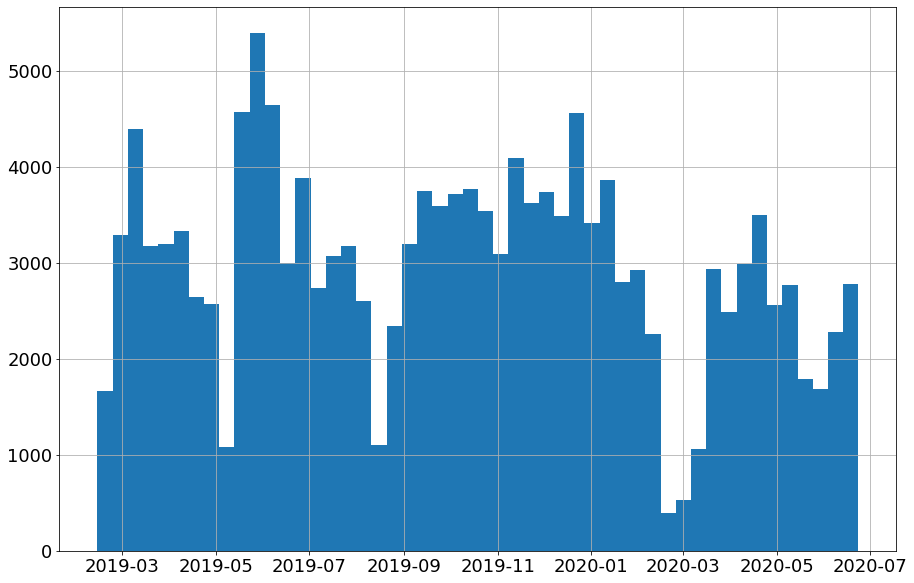

In [6]:
df.timestamp.hist(bins=50, figsize=plot_size);

Делим выборку на тренировочную и тестовую.

In [7]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, random_state=42)

Для обработки слов будем использовать _CountVectorizer_ и _TfidfTransformer_. Решаем задчу классификации с булевыми входными данными, поэтому в качестве алгоритма предскания я выбрал наивный байесовский классификатор _BernoulliNB_.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import BernoulliNB

from sklearn.pipeline import Pipeline

message_classifier = Pipeline([
    ('vectorizer', CountVectorizer()), 
    ('tfidf_transformer', TfidfTransformer()),
    ('bernoulli_naive_bayes', BernoulliNB()),
], verbose=10000)


Обучаем модель.

In [9]:
message_classifier.fit(df_train.text, df_train.is_out)

[Pipeline] ........ (step 1 of 3) Processing vectorizer, total=   0.9s
[Pipeline] . (step 2 of 3) Processing tfidf_transformer, total=   0.0s
[Pipeline]  (step 3 of 3) Processing bernoulli_naive_bayes, total=   0.0s


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_transformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('bernoulli_naive_bayes',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                             fit_prior=True))

In [10]:
score = message_classifier.score(df_test.text, df_test.is_out)
print(f"Точность: {round(100 * score, 2)}%")

Точность: 65.58%


Примеры работы, предсказания и использования:

In [11]:
messages = ["Спокойной ночи", 
            "Сладких снов", 
            "Как же офигенно прогать", 
            "Я так много раз делала", 
            "Как я ненавижу себя в такие моменты", 
            "Как ты вообще к спойлерам относишься?"]

correct = [1, 0, 1, 0, 0, 1]
types = ["входящее", "исходящее"]

results = message_classifier.predict(messages)
results_proba = message_classifier.predict_proba(messages)

for i, answer in enumerate(results):
    print(f"Мне кажется, что сообщение \"{messages[i]}\" {types[answer]}.")
    print(f"Моя уверенность составляла {results_proba[i][answer]}")
    print(f"Правильный ответ - это сообщение {types[correct[i]]}.\n")

Мне кажется, что сообщение "Спокойной ночи" исходящее.
Моя уверенность составляла 0.995748068314301
Правильный ответ - это сообщение исходящее.

Мне кажется, что сообщение "Сладких снов" входящее.
Моя уверенность составляла 0.9976632467819107
Правильный ответ - это сообщение входящее.

Мне кажется, что сообщение "Как же офигенно прогать" исходящее.
Моя уверенность составляла 0.8789767224462948
Правильный ответ - это сообщение исходящее.

Мне кажется, что сообщение "Я так много раз делала" входящее.
Моя уверенность составляла 0.7334198601899784
Правильный ответ - это сообщение входящее.

Мне кажется, что сообщение "Как я ненавижу себя в такие моменты" входящее.
Моя уверенность составляла 0.6174293269185352
Правильный ответ - это сообщение входящее.

Мне кажется, что сообщение "Как ты вообще к спойлерам относишься?" исходящее.
Моя уверенность составляла 0.5969493737512461
Правильный ответ - это сообщение исходящее.



Эти функции можно использовать для предсказания результата. _test_ выдаёт один ответ, _test_proba_ возвращает вероятности

In [12]:
def test(message):
    result = message_classifier.predict([message])[0]
    return types[result]

def test_proba(message):
    result = message_classifier.predict_proba([message])[0]
    
    return {types[0]: result[0], types[1]: result[1]}

print(test_proba("Спокойной ночи)"))

{'входящее': 0.004251931685699403, 'исходящее': 0.995748068314301}


Оценим качество предсказний. Здесь показаны метрици качества предсказаний:

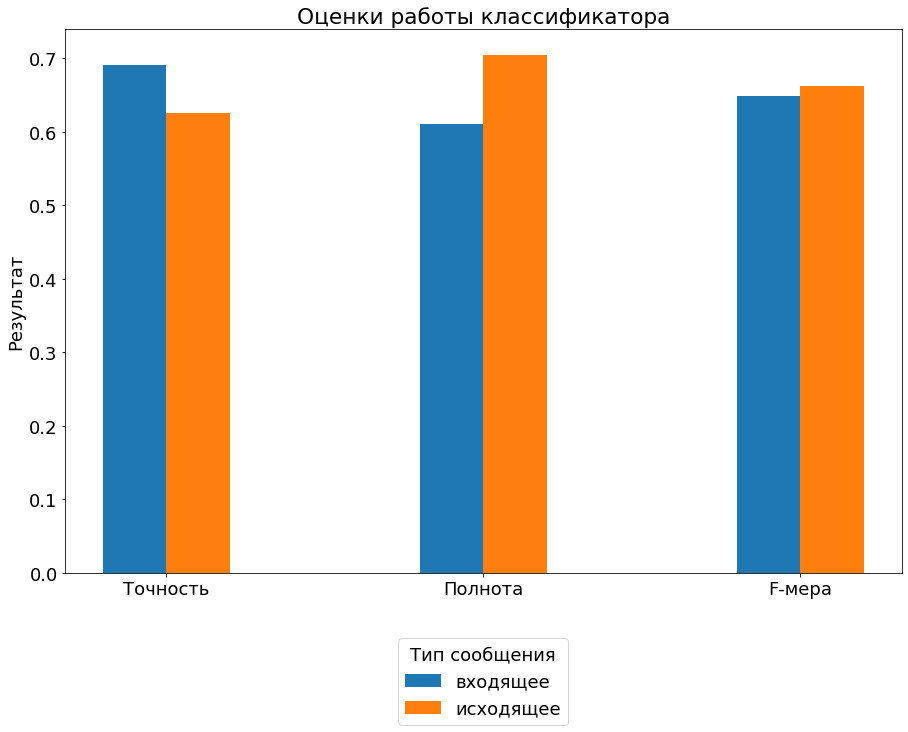

In [13]:
from sklearn.metrics import precision_recall_fscore_support

precision_score, recall_score, f_score, support = precision_recall_fscore_support(
    df_test.is_out, 
    message_classifier.predict(df_test.text)
)
scores = np.array([precision_score, recall_score, f_score])
_, ax = plt.subplots(figsize=plot_size)

indexes = np.arange(len(scores))

ax.set_xticks(indexes)
ax.set_xticklabels(('Точность', 'Полнота', 'F-мера'))
ax.set_title('Оценки работы классификатора')
ax.set_ylabel('Результат')

bar_width = 0.2
ax.bar(indexes - bar_width / 2, scores[:, 0], bar_width, label=types[0])
ax.bar(indexes + bar_width / 2, scores[:, 1], bar_width, label=types[1])
ax.legend(bbox_to_anchor=(0.5, -0.2), loc="center", title="Тип сообщения",);

roc-кривая:

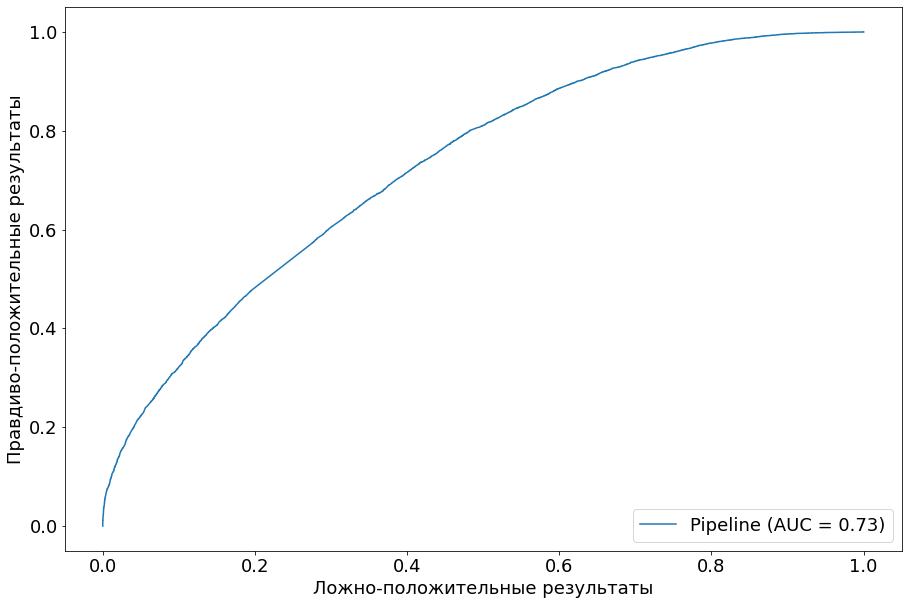

In [14]:
from sklearn.metrics import plot_roc_curve

_, ax = plt.subplots(figsize=plot_size)
rc = plot_roc_curve(message_classifier, df_test.text, df_test.is_out, ax=ax)
ax.set_xlabel("Ложно-положительные результаты")
ax.set_ylabel("Правдиво-положительные результаты");

И матрица ошибок:

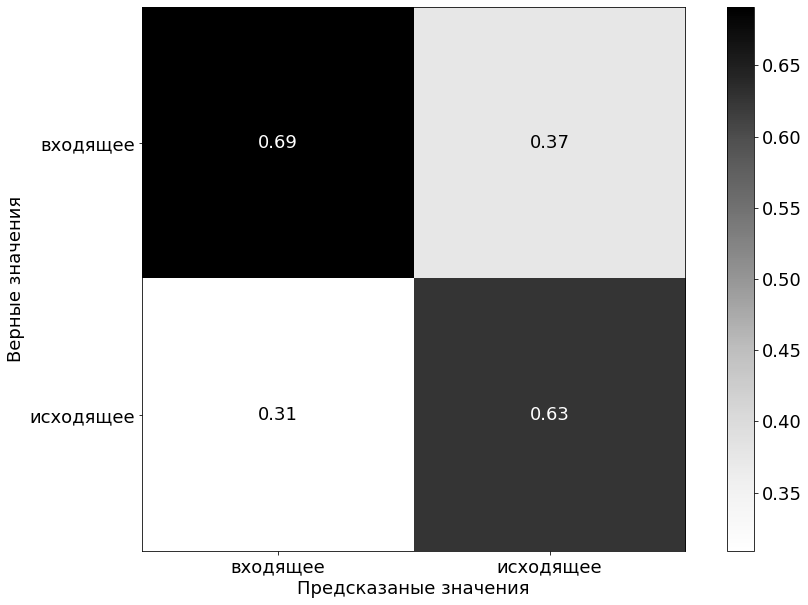

In [15]:
from sklearn.metrics import plot_confusion_matrix

labels = types
_, ax = plt.subplots(figsize=plot_size)
cm = plot_confusion_matrix(
    message_classifier, 
    df_test.text, 
    df_test.is_out, 
    normalize='pred', 
    cmap=plt.cm.Greys, 
    display_labels=labels, 
    ax=ax
)
cm.ax_.set_xlabel("Предсказаные значения")
cm.ax_.set_ylabel("Верные значения");

Как мы можем видеть, предсказания не идеальные. Скорее всего это произошло из-за того, что довольно много сообщений могли быть отправлены как одним человеком, так и вторым (к примеру, "Привет", "Как дела", "Ладно", "Почему?", "Хорошо"), и эти сообщения довольно популярны. Однако, если взять работу классификатора по модулю невозможности предсказания на таких сообщениях, он работает достойно. 
Преимущество _TfidfTransformer_ в сочетании с классификатором _BernoulliNB_ состоит в том, что вектора признаков хранятся разреженно, поэтому занимают меньше места и позволяют обучать быстрее (обучение на 900 тысячах сообщений проходит меньше, чем за секунду).